# Cairo lattice ACI

    In this notebook, I will perform the first steps of the simulations of a Cairo lattice. I will start by applying a magnetic field ramp and save the trajectories in order to analyze (In other notebook) the vertex fraction versus the interparticle interaction. This way, we will be able to conclude if the lattice is degenerate or not. 

In [1]:
import os
import sys
import numpy as np
from importlib import reload  
import support as sup
reload(sup)
sys.path.insert(0, '../icenumerics')

import icenumerics as ice

from icenumerics.geometry import ordering 
import magcolloids as mgc

import matplotlib.pyplot as plt
ureg = ice.ureg

%load_ext autoreload
%autoreload 2

In [2]:
output = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts/Output_Script-1.0"

    I'm using this lattice contant parameter because is the same as the experimental microstructures. The same occur with the two type trap_sep parameter.

In [3]:
np.random.seed()

l = 5

sp = sup.spins()
ureg = ice.ureg
sp.create_lattice(geometry = "cairo",size =[l,l],lattice_constant=19.5458*ureg.um, border="closed spin")
sp.order_spins(ordering.random_ordering)

/home/carolina/CairoLattice_ACI_PROJECT/Scripts/support.py:62: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new[:,0] = centers_toAddX
/home/carolina/CairoLattice_ACI_PROJECT/Scripts/support.py:63: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new[:,1] = centers_toAddY
/home/carolina/CairoLattice_ACI_PROJECT/Scripts/support.py:105: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  new_centers[:,1] = centersY


In [4]:
particle = ice.particle(radius = 5*ureg.um,
             susceptibility = 0.005,
             diffusion = 0.125*ureg.um**2/ureg.s,
             temperature = 300*ureg.K,
             density = 1000*ureg.kg/ureg.m**3)

trap_long = ice.trap(trap_sep = 10*ureg.um,
               height = 0.3*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

trap_short = ice.trap(trap_sep = 4.5258*ureg.um,
               height = 0.3*ureg.pN*ureg.nm,
               stiffness = 6e-4*ureg.pN/ureg.nm)

traps = []

    In this Kenrel I will define which traps have to be shorter

In [5]:
for s in sp:
    
    if ( s.direction[0].magnitude == 1.0 or s.direction[0].magnitude == -1.0 or 
        s.direction[1].magnitude == 1.0 or s.direction[1].magnitude == -1.0 ):
        
        traps.append(trap_short)
        
    else:
        
        traps.append(trap_long)

In [6]:
col = ice.colloidal_ice(sp, particle, traps, height_spread = 0, susceptibility_spread = 0.1)

col.pad_region(5*ureg.um) # Why is this important?? Whitout this line the simulation do not run.  

In [7]:
world = ice.world(
    field = 50*ureg.mT,
    temperature = 300*ureg.K,
    dipole_cutoff = 200*ureg.um)

In [8]:
total_time = 1200*ureg.s
col.simulate(world,
             name = "ACI_CairoLattice_l%u_15mT-800s"%(l),
             include_timestamp = False,
             targetdir = output,
             framerate = 1*ureg.Hz,
             timestep = 10*ureg.ms,
             run_time = total_time,
             output = ["x","y","z","mux","muy","muz"])

# Porque parece que corra la simulacion directamente desde aqui??

scanning file


In [9]:
col.sim.field.fieldz = "v_Bmag*time/%f"%total_time.to(ureg.us).magnitude
col.run_simulation()

In [10]:
col.load_simulation(slice(0,None,1))

scanning file


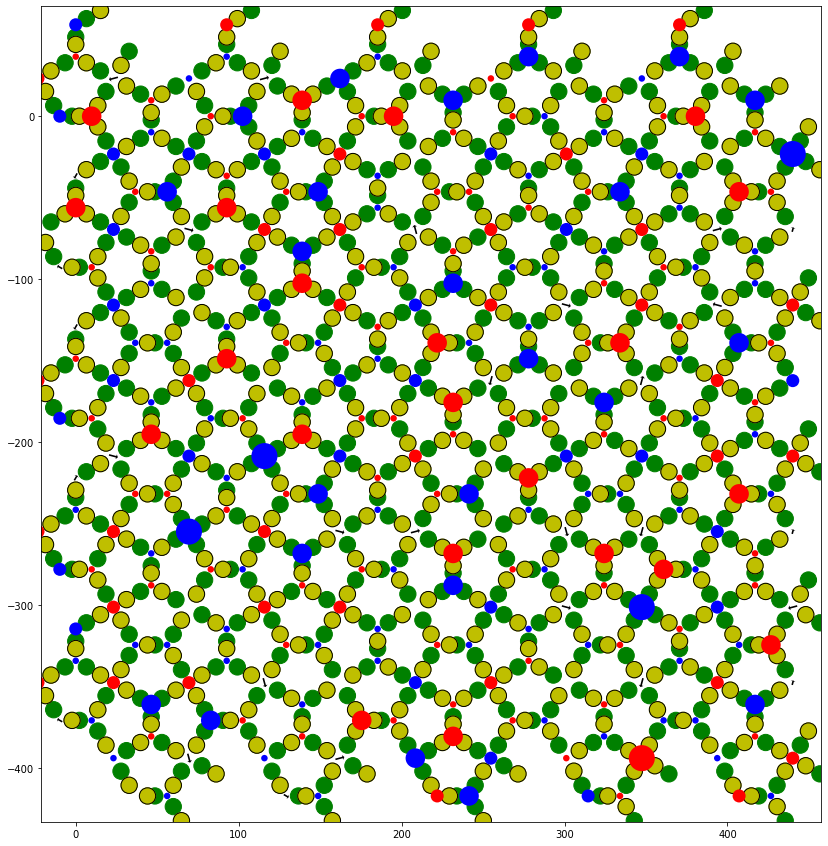

In [11]:
f, (ax1) = plt.subplots(1,1,figsize = (15,15))
v = ice.vertices()
col.set_state_from_frame(0)
v = v.colloids_to_vertices(col)

col.display(ax1)
v.display(ax1)

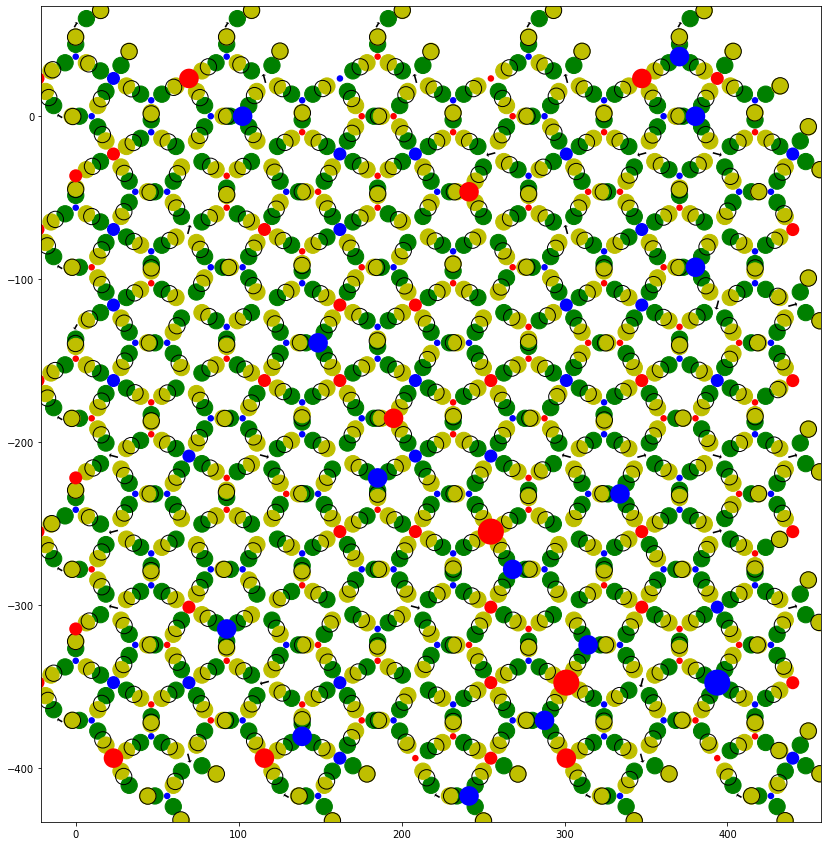

In [12]:
f, (ax1) = plt.subplots(1,1,figsize = (15,15))
v = ice.vertices()
col.set_state_from_frame(-1)
v = v.colloids_to_vertices(col)

col.display(ax1)
v.display(ax1)

In [26]:
v.vertices

x           y  coordination  charge        dx        dy
frame                                                                      
0      0   162.128394 -115.901194             4       4  0.000000  0.000000
       1   148.743700 -139.084000             3      -1 -1.000000  1.732051
       2   129.197920 -139.084000             2       2 -0.500000 -0.866025
       3    23.161109   23.189083             4       0  2.732051  0.732050
       4   129.176342  -46.380402             3       1 -1.000000  1.732051
...               ...         ...           ...     ...       ...       ...
120000 43   92.647102   36.579180             3      -1 -1.732051  1.000000
       44   92.647102   56.124669             2       0  0.866025  1.500000
       45   23.155934  -69.523823             4       0 -2.732051 -0.732050
       46    9.773014  -92.704002             3      -1 -1.000000 -1.732051
       47   -9.772840  -92.704002             2       0 -1.500000  0.866025

[5808 rows x 6 columns]

In [29]:
v.vertices.groupby('frame')['charge'].value_counts().loc[120000]

charge
-1    16
 0    11
 1     9
-2     5
 2     4
-3     2
 3     1
Name: charge, dtype: int64

# How much space do the particles explore?

In [15]:
col.trj.x

frame  id  
0      1         2.262900
       2       -18.546101
       3       -15.195700
       4         6.535400
       5        13.546100
                  ...    
1200   996     432.958008
       997     432.958008
       998     452.398010
       999     447.188995
       1000    427.777008
Name: x, Length: 1201000, dtype: float32

In [16]:
ids = col.trj.groupby('id')

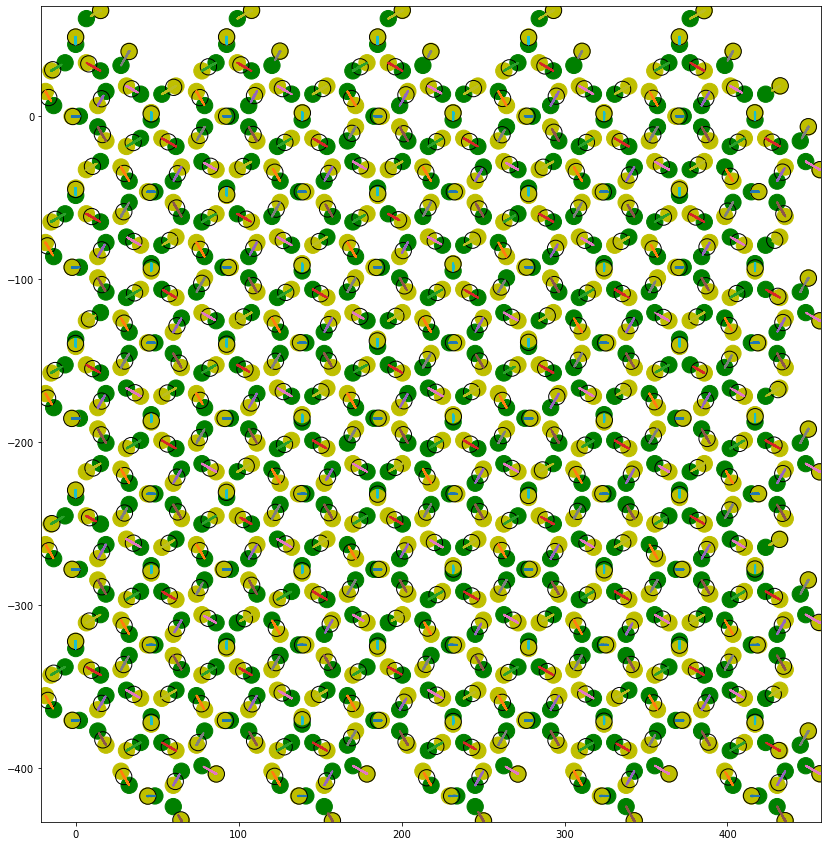

In [17]:
f, (ax1) = plt.subplots(1,1,figsize = (15,15))

col.set_state_from_frame(-1)

col.display(ax1)


for i, int in ids:
    
    plt.plot(int.x, int.y)


# Is possible to compute vertices 'a posteriori' ?

In [18]:
load_obj = mgc.trj_lazyread(os.path.join(output,"ACI_CairoLattice_l2_15mT-800s.lammpstrj"), output = ["x","y","z","mux","muy","muz"])

In [19]:
bnd = load_obj.get_bounds()
trj = load_obj.read_trj()

In [20]:
trj

type           x           y    z      mux      muy  muz
frame  id                                                           
0      1       1    2.262900    0.000000  0.0  0.00000  0.00000  0.0
       2       1  -18.546101   15.195700  0.0  0.00000  0.00000  0.0
       3       1  -15.195700   27.805901  0.0  0.00000  0.00000  0.0
       4       1   15.195700   27.805901  0.0  0.00000  0.00000  0.0
       5       1   18.546101   15.195700  0.0  0.00000  0.00000  0.0
...          ...         ...         ...  ...      ...      ...  ...
120000 156     3  155.016998 -128.218994  0.0  5.00000  8.66025  0.0
       157     3  155.016998 -149.949997  0.0 -5.00000  8.66025 -0.0
       158     3  174.457001 -123.038002  0.0 -8.66025  5.00000 -0.0
       159     3  169.248001 -103.569000  0.0 -5.00000 -8.66025 -0.0
       160     3  149.835999  -76.686302  0.0  8.66025  5.00000  0.0

[192160 rows x 7 columns]

In [21]:
col_trj = ice.get_ice_trj(trj,bnd, atom_types = 1, trap_types = [2,3])

In [22]:
col_trj.loc[120000]

,type,x,y,z,dx,dy,dz,cx,cy,cz
id,,,,,,,,,,
0,2,0.000000,0.000000,0.0,-4.52580,-0.00000,-0.0,-2.308490,-0.024948,0.0
1,2,0.000000,46.352001,0.0,0.00000,4.52580,0.0,-0.052148,2.284901,0.0
2,2,46.323502,-46.380402,0.0,-4.52580,-0.00000,-0.0,-1.842300,0.020302,0.0
3,2,46.323502,-0.028435,0.0,0.00000,4.52580,0.0,-0.112801,2.118515,0.0
4,2,92.647102,0.000000,0.0,-4.52580,-0.00000,-0.0,-0.112000,-0.149052,0.0
...,...,...,...,...,...,...,...,...,...,...
75,3,155.016998,-128.218994,0.0,-5.00000,-8.66025,-0.0,-0.724991,-1.376007,0.0
76,3,155.016998,-149.949997,0.0,5.00000,-8.66025,0.0,2.277008,-4.056000,0.0
77,3,174.457001,-123.038002,0.0,8.66025,-5.00000,0.0,3.878006,-2.077995,0.0


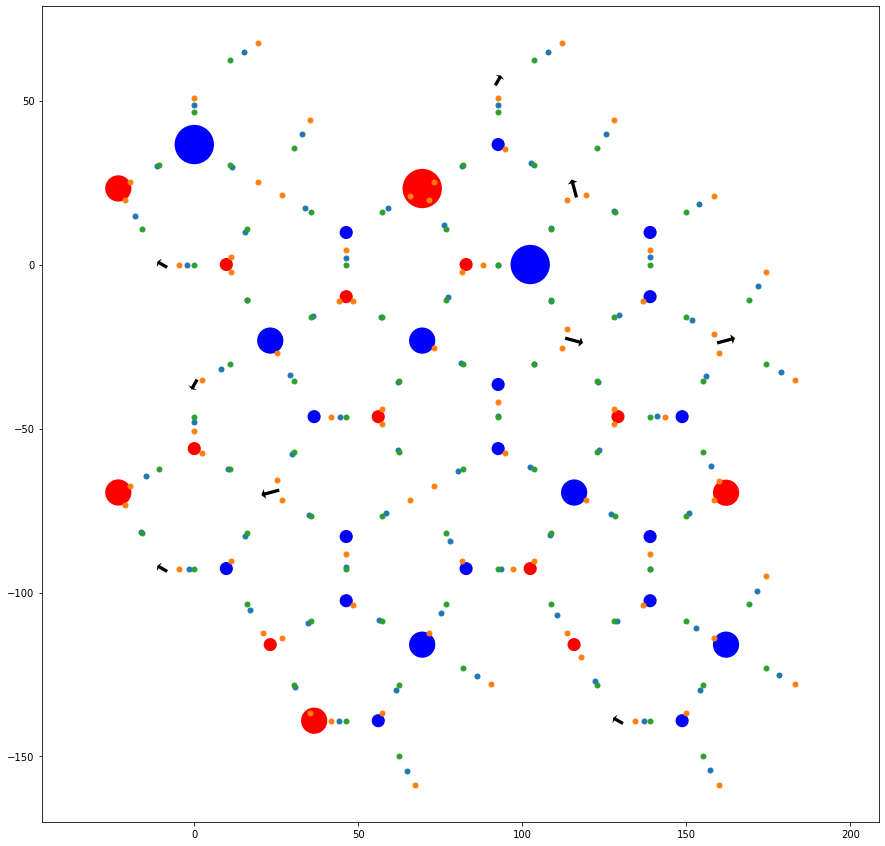

In [23]:
f, (ax1) = plt.subplots(1,1,figsize = (15,15))

v = ice.vertices()
#v.trj_to_vertices(col_trj.loc[frames[::1]]) # Analog to v.trj_to_vertices(col_trj)
v.trj_to_vertices(col_trj.loc[120000])

plt.plot(col_trj.loc[120000].x+col_trj.loc[120000].cx,
         col_trj.loc[120000].y+col_trj.loc[120000].cy, 'o', markersize = 5)

plt.plot(col_trj.loc[120000].x+col_trj.loc[120000].dx,
         col_trj.loc[120000].y+col_trj.loc[120000].dy, '.', markersize = 10)

plt.plot(col_trj.loc[120000].x, col_trj.loc[120000].y, '.', markersize = 10)
plt.axis('equal')
v.display(ax1)

In [24]:
## Infer Vertices
frames = col_trj.index.get_level_values("frame").unique()

v = ice.vertices()
v.trj_to_vertices(col_trj.loc[frames[::10]])

In [25]:
v.vertices.loc[80000].query('charge == -4')

,x,y,coordination,charge,dx,dy
25,69.486796,-69.550337,4,-4,0.0,0.0


# Issues

    
    - 1. ice.get_ice_trj() function is not working properly. It only works for one type of particles and traps.
        (Solution: Allow to have more than one type of trap. Modified function in support.py file)
        
<font color='red'> SOLVED! </font>
        
    - 2. trj_to_vertices() function is not working properly. It cannot reproduce the vertex dataframe obtained with the col object.
        (Solution: The directions are not well defined. The pairs trap-particle are not correct!)
    
<font color='red'> @aortiza SOLVED the problem in commit 983bfff the trjayectory.py file was sostituted by the one of the commit</font>